<a href="https://colab.research.google.com/github/sulimankhan587/CNN_Car_Detection/blob/main/phd_khalil_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q cleverhans
!pip install -q plot_keras_history
!pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.models import load_model


from sklearn.metrics import mean_squared_error
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
import numpy as np

import seaborn as sns
import pandas as pd

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
GOOGLE_COLAB = True

PROJECT_FOLDER = ''

np.random.seed(10)

In [ ]:

!wget -q -O data.mat https://github.com/ocatak/6g-channel-estimation-dataset/blob/main/data.mat?raw=true
!wget -q -O util_defdistill.py https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/util_defdistill.py
from util_defdistill import Distiller

In [ ]:
data = scipy.io.loadmat(PROJECT_FOLDER + 'data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

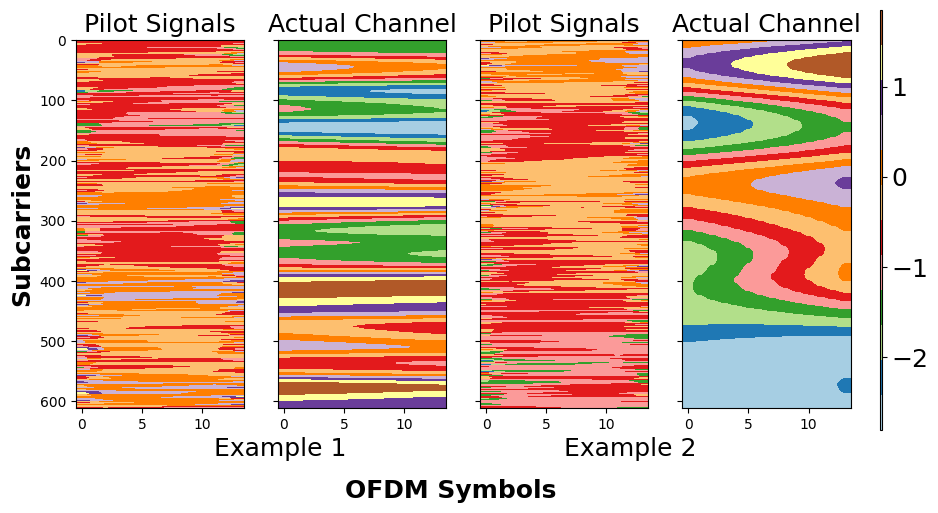

In [ ]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

plt.show()

In [ ]:
def get_model(mult_factor=1.0, model_name=''):
    model = models.Sequential(name=model_name)
    # Changing activation functions and adding BatchNormalization
    model.add(layers.Conv2D(int(48 * mult_factor), (9, 9), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))  # Changed activation function

    model.add(layers.Conv2D(int(16 * mult_factor), (5, 5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))  # Changed activation function

    model.add(layers.Conv2D(1, (5, 5), padding='same'))
    model.add(layers.Activation('linear'))  # Linear activation for output layer

    return model


## Undefended Model

In [ ]:
CHILD_MODEL_MULTIPLICATION = 0.5
PARENT_MODEL_MULTIPLICATION = 1.0

In [ ]:
model = get_model(CHILD_MODEL_MULTIPLICATION, model_name = 'Child')

In [ ]:

model = get_model(CHILD_MODEL_MULTIPLICATION, model_name = 'Child')

es_teacher = EarlyStopping(monitor='val_loss',
                          patience=50,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_model = model.fit(trainData, trainLabels,
              epochs=500,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [ ]:
plot_history(hist_model.history)
plt.show()

NameError: name 'hist_model' is not defined

1/1 [==============================] - 0s 375ms/step


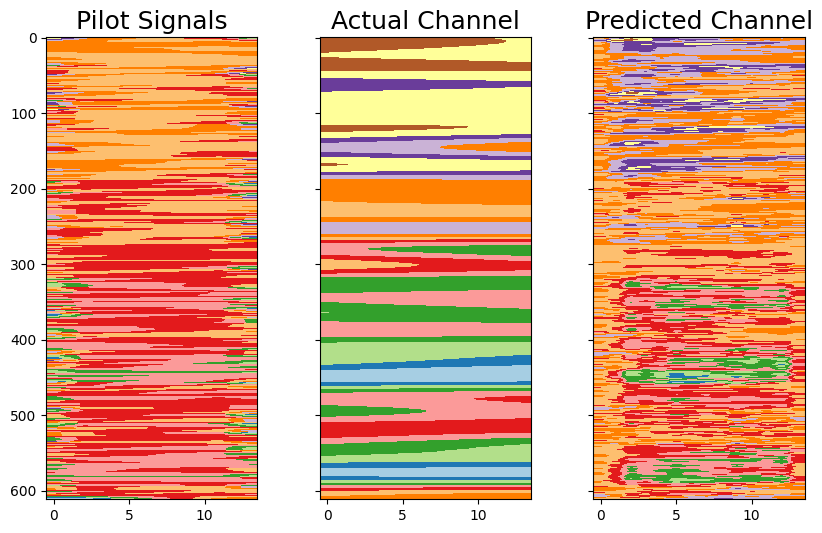

In [ ]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [ ]:
child_model = get_model(CHILD_MODEL_MULTIPLICATION, model_name = 'Child')
parent_model = get_model(PARENT_MODEL_MULTIPLICATION, model_name = 'Parent')

In [ ]:
es_teacher = EarlyStopping(monitor='val_loss',
                          patience=200,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

parent_model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_parent = parent_model.fit(trainData, trainLabels,
              epochs=500,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

KeyboardInterrupt: 

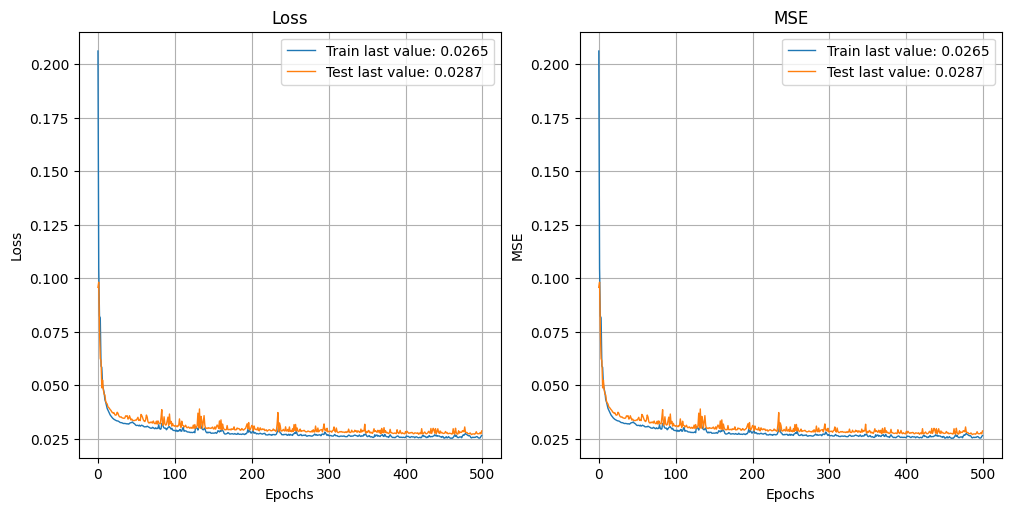

In [ ]:
plot_history(hist_parent.history)
plt.show()

1/1 [==============================] - 0s 91ms/step


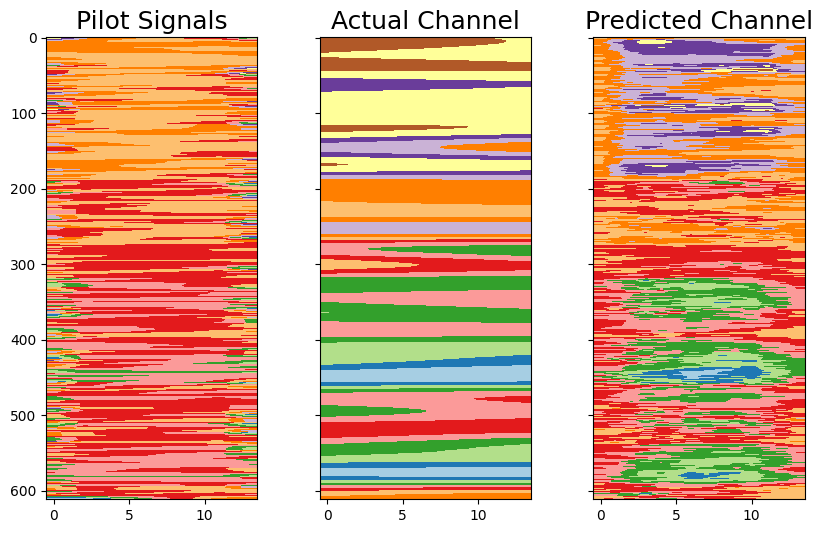

In [ ]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = parent_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [ ]:
import keras
distiller = Distiller(student=child_model, teacher=parent_model)
loss_fn = keras.losses.MeanSquaredError()

distiller.compile(optimizer='adam',
                            metrics=['mse'],
                            student_loss_fn=loss_fn,
                            distillation_loss_fn=keras.losses.KLDivergence(),
                            alpha=0.1,
                            temperature=20)

es = EarlyStopping(monitor='val_student_loss',
                   patience=150,
                   #min_delta=0.000001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

hist_distill = distiller.fit(trainData, trainLabels,
                              epochs=500,
                              verbose=0,
                              callbacks=[es,TqdmCallback(verbose=1, desc='DL training')],
                              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

KeyboardInterrupt: 

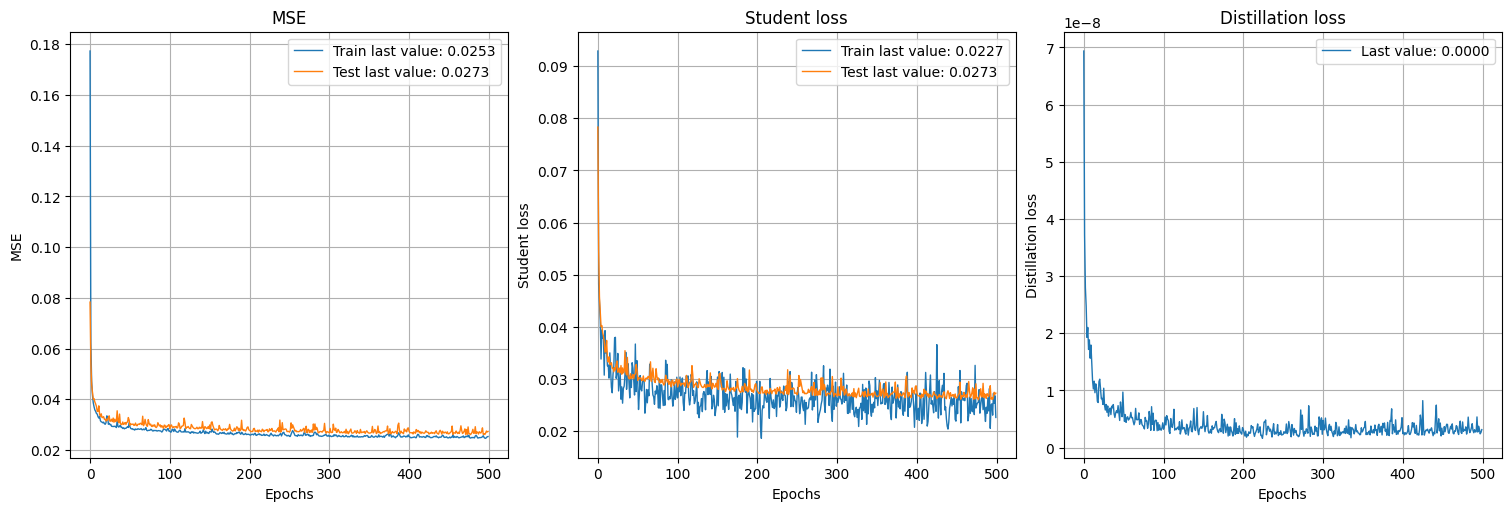

In [ ]:
plot_history(hist_distill.history)
plt.show()

1/1 [==============================] - 0s 93ms/step


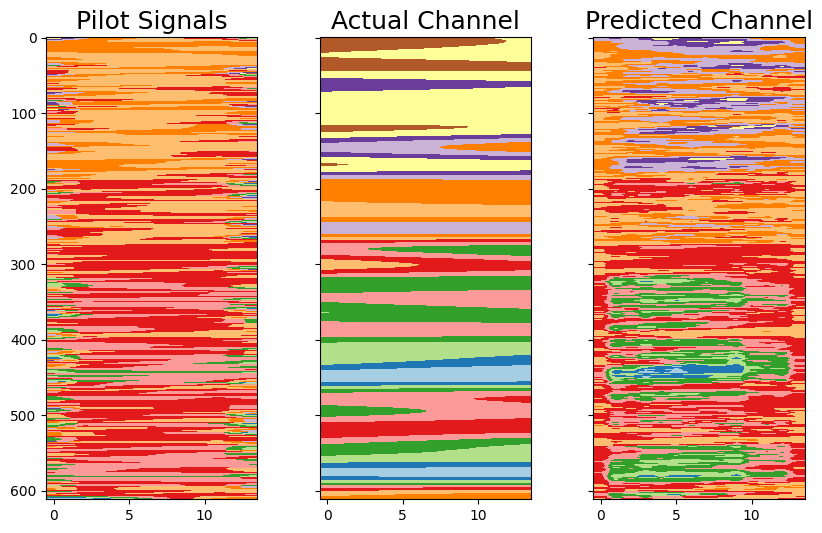

In [ ]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = child_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [ ]:

from keras.layers import Dense, Flatten
student_copy = tf.keras.models.clone_model(distiller.student)
for layer in student_copy.layers:
    	layer.trainable = False

student_copy.add(Flatten())
student_copy.add(Dense(2, activation='softmax'))
student_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
logits_model_student = tf.keras.Model(student_copy.input, student_copy.output)

#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []

eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)

    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model_student, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model_student, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())

        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation_def_distill.csv', mode='a', header=False, index=False)

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


In [ ]:
logits_model_student = tf.keras.Model(student_copy.input, student_copy.output)

#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []

eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)

    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model_student, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model_student, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())

        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation_def_distill_2.csv', mode='a', header=False, index=False)

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


In [ ]:
model_copy = tf.keras.models.clone_model(model)
for layer in model_copy.layers:
    	layer.trainable = False

model_copy.add(Flatten())
model_copy.add(Dense(2, activation='softmax'))
model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
logits_model = tf.keras.Model(model_copy.input, model_copy.output)
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]
eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)
    #for eps_val in eps_vals:
    #  for attack in attacks:
    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())

        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation_2.csv', mode='a', header=False, index=False)

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


In [ ]:
COL_NAMES = ['Malicious_Distance','Real_Predicted_MSE','Malicious_Predicted_MSE','MalOut_RealOut_Diff'
             ,'Attack','eps']
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

df_undefended = pd.read_csv('/content/channel_estimation.csv', names=COL_NAMES)
df_undefended = df_undefended.query("Malicious_Predicted_MSE < 1.0").sort_values(by=['Attack'])



In [ ]:
import pandas as pd

# Read the CSV file
df_distilled = pd.read_csv('/content/channel_estimation_def_distill.csv')

# Convert 'Malicious_Predicted_MSE' column to float
df_distilled['Malicious_Predicted_MSE'] = df_distilled['Malicious_Predicted_MSE'].astype(float)

# Query the DataFrame
df_distilled = df_distilled.query("Malicious_Predicted_MSE < 1.0").sort_values(by=['Attack'])

# Display a sample of the DataFrame
df_distilled.sample(10)

,Values,Malicious_Distance,Real_Predicted_MSE,Malicious_Predicted_MSE,MalOut_RealOut_Diff,Attack,eps
4,493,0.140001,0.023396,0.023092,0.048550,FGSM,0.1
3,154,2.799999,0.016959,0.017671,0.834533,PGD,3.0
5,128,2.800005,0.028594,0.029279,0.837483,MIM,1.0
6,353,0.140000,0.020492,0.020525,0.041318,FGSM,0.1
8,537,2.800003,0.022326,0.024685,0.779131,MIM,3.0
7,144,1.400000,0.016659,0.016763,0.463262,PGD,0.1
0,611,2.800021,0.007213,0.008475,0.819117,BIM,2.0
9,420,1.400000,0.040717,0.041198,0.475293,FGSM,1.0
2,272,4.200001,0.001787,0.005060,1.442788,FGSM,3.0
1,125,2.800014,0.028594,0.029215,0.882066,BIM,0.5


from matplotlib import pyplot as plt
_df_34['Values'].plot(kind='hist', bins=20, title='Values')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35['Malicious_Distance'].plot(kind='hist', bins=20, title='Malicious_Distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36['Real_Predicted_MSE'].plot(kind='hist', bins=20, title='Real_Predicted_MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['Malicious_Predicted_MSE'].plot(kind='hist', bins=20, title='Malicious_Predicted_MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_38.groupby('Attack').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_39.plot(kind='scatter', x='Values', y='Malicious_Distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_40.plot(kind='scatter', x='Malicious_Distance', y='Real_Predicted_MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41.plot(kind='scatter', x='Real_Predicted_MSE', y='Malicious_Predicted_MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_42.plot(kind='scatter', x='Malicious_Predicted_MSE', y='MalOut_RealOut_Diff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_43['Values'].plot(kind='line', figsize=(8, 4), title='Values')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_44['Malicious_Distance'].plot(kind='line', figsize=(8, 4), title='Malicious_Distance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_45['Real_Predicted_MSE'].plot(kind='line', figsize=(8, 4), title='Real_Predicted_MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_46['Malicious_Predicted_MSE'].plot(kind='line', figsize=(8, 4), title='Malicious_Predicted_MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_47['Attack'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_47, x='Values', y='Attack', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_48['Attack'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_48, x='Malicious_Distance', y='Attack', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_49['Attack'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_49, x='Real_Predicted_MSE', y='Attack', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_50['Attack'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_50, x='Malicious_Predicted_MSE', y='Attack', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

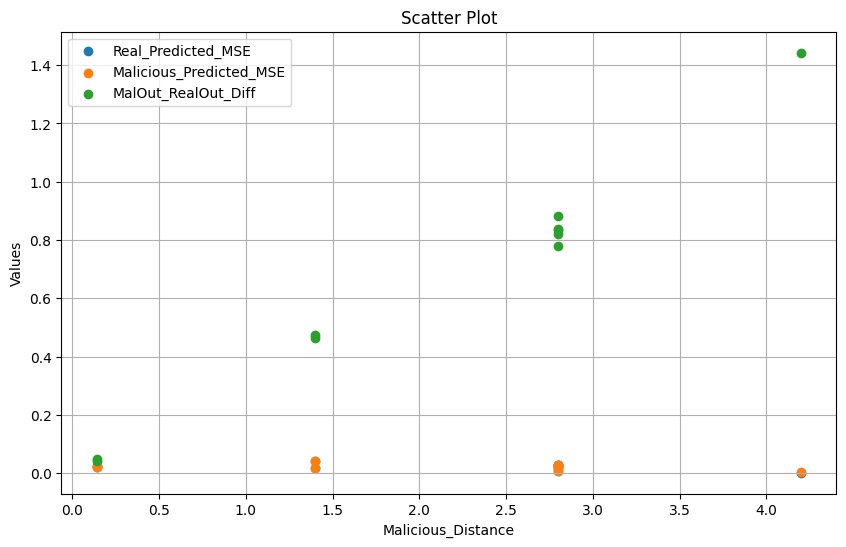

In [ ]:
import matplotlib.pyplot as plt

# Data
Malicious_Distance = [2.800021, 2.800014, 4.200001, 2.799999, 0.140001, 2.800005, 0.140000, 1.400000, 2.800003, 1.400000]
Real_Predicted_MSE = [0.007213, 0.028594, 0.001787, 0.016959, 0.023396, 0.028594, 0.020492, 0.016659, 0.022326, 0.040717]
Malicious_Predicted_MSE = [0.008475, 0.029215, 0.00506, 0.017671, 0.023092, 0.029279, 0.020525, 0.016763, 0.024685, 0.041198]
MalOut_RealOut_Diff = [0.819117, 0.882066, 1.442788, 0.834533, 0.048550, 0.837483, 0.041318, 0.463262, 0.779131, 0.475293]
Attack = ['BIM', 'BIM', 'FGSM', 'PGD', 'FGSM', 'MIM', 'FGSM', 'PGD', 'MIM', 'FGSM']
eps = [2.0, 0.5, 3.0, 3.0, 0.1, 1.0, 0.1, 0.1, 3.0, 1.0]


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Malicious_Distance, Real_Predicted_MSE, label='Real_Predicted_MSE')
plt.scatter(Malicious_Distance, Malicious_Predicted_MSE, label='Malicious_Predicted_MSE')
plt.scatter(Malicious_Distance, MalOut_RealOut_Diff, label='MalOut_RealOut_Diff')
plt.xlabel('Malicious_Distance')
plt.ylabel('Values')
plt.title('Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()


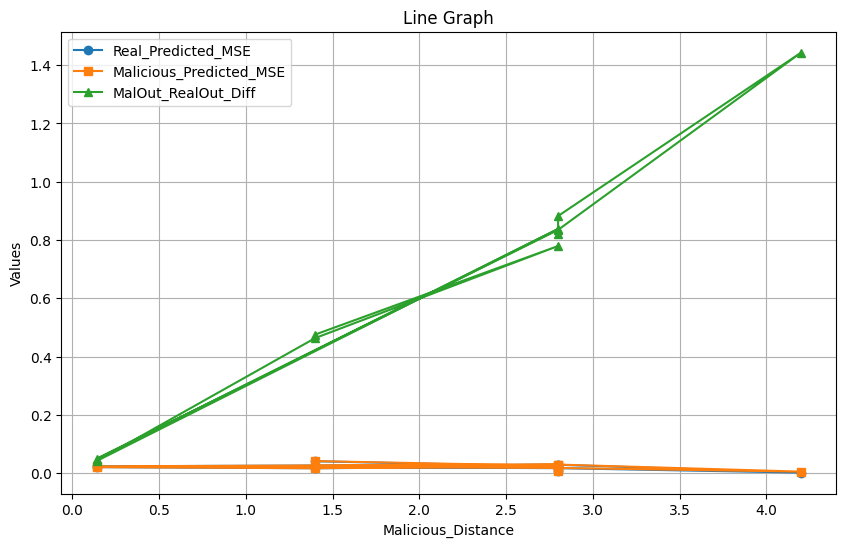

In [ ]:
import matplotlib.pyplot as plt

# Data
Malicious_Distance = [2.800021, 2.800014, 4.200001, 2.799999, 0.140001, 2.800005, 0.140000, 1.400000, 2.800003, 1.400000]
Real_Predicted_MSE = [0.007213, 0.028594, 0.001787, 0.016959, 0.023396, 0.028594, 0.020492, 0.016659, 0.022326, 0.040717]
Malicious_Predicted_MSE = [0.008475, 0.029215, 0.00506, 0.017671, 0.023092, 0.029279, 0.020525, 0.016763, 0.024685, 0.041198]
MalOut_RealOut_Diff = [0.819117, 0.882066, 1.442788, 0.834533, 0.048550, 0.837483, 0.041318, 0.463262, 0.779131, 0.475293]
Attack = ['BIM', 'BIM', 'FGSM', 'PGD', 'FGSM', 'MIM', 'FGSM', 'PGD', 'MIM', 'FGSM']
eps = [2.0, 0.5, 3.0, 3.0, 0.1, 1.0, 0.1, 0.1, 3.0, 1.0]


# Line graph
plt.figure(figsize=(10, 6))
plt.plot(Malicious_Distance, Real_Predicted_MSE, marker='o', label='Real_Predicted_MSE')
plt.plot(Malicious_Distance, Malicious_Predicted_MSE, marker='s', label='Malicious_Predicted_MSE')
plt.plot(Malicious_Distance, MalOut_RealOut_Diff, marker='^', label='MalOut_RealOut_Diff')
plt.xlabel('Malicious_Distance')
plt.ylabel('Values')
plt.title('Line Graph')
plt.legend()
plt.grid(True)
plt.show()


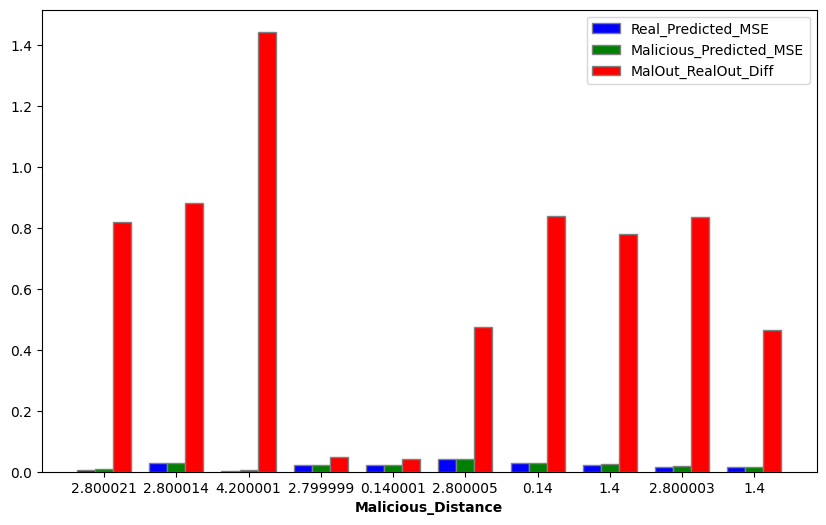

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Malicious_Distance = [2.800021, 2.800014, 4.200001, 2.799999, 0.140001, 2.800005, 0.140000, 1.400000, 2.800003, 1.400000]
Real_Predicted_MSE = [0.007213, 0.028594, 0.001787, 0.016959, 0.023396, 0.028594, 0.020492, 0.016659, 0.022326, 0.040717]
Malicious_Predicted_MSE = [0.008475, 0.029215, 0.00506, 0.017671, 0.023092, 0.029279, 0.020525, 0.016763, 0.024685, 0.041198]
MalOut_RealOut_Diff = [0.819117, 0.882066, 1.442788, 0.834533, 0.048550, 0.837483, 0.041318, 0.463262, 0.779131, 0.475293]
Attack = ['BIM', 'BIM', 'FGSM', 'PGD', 'FGSM', 'MIM', 'FGSM', 'PGD', 'MIM', 'FGSM']
eps = [2.0, 0.5, 3.0, 3.0, 0.1, 1.0, 0.1, 0.1, 3.0, 1.0]


# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = np.arange(len(Malicious_Distance))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(r1, df_distilled['Real_Predicted_MSE'], color='b', width=bar_width, edgecolor='grey', label='Real_Predicted_MSE')
plt.bar(r2, df_distilled['Malicious_Predicted_MSE'], color='g', width=bar_width, edgecolor='grey', label='Malicious_Predicted_MSE')
plt.bar(r3, df_distilled['MalOut_RealOut_Diff'], color='r', width=bar_width, edgecolor='grey', label='MalOut_RealOut_Diff')

# Add xticks on the middle of the group bars
plt.xlabel('Malicious_Distance', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(Malicious_Distance))], Malicious_Distance)

# Add a legend
plt.legend()

# Show the graph
plt.show()
